<a href="https://colab.research.google.com/github/WMPantaleao/urban_scaling_covid/blob/main/log_bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

df_eua_r0 = pd.read_csv('df_eua_r0.csv', sep = ',', encoding = 'iso-8859-1')
df_eua_r0 = df_eua_r0.drop(['Unnamed: 0'], 1)
df_eua_r0

<ipython-input-3-6d34ca091511>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_eua_r0 = df_eua_r0.drop(['Unnamed: 0'], 1)


,POP,RHO,R0
0,12728,5.458437,1.969645
1,12769,5.078196,1.600058
2,13283,1.081227,1.568395
3,13901,1.104720,1.801116
4,14070,13.179438,1.820267
...,...,...,...
904,7066141,330.364964,4.937268
905,7643907,318.105437,4.606079
906,9458539,507.438780,4.261670
907,13214799,1052.344357,3.794805


In [21]:
import numpy as np

df_eua_sort = df_eua_r0.sort_values(by = ['POP']).reset_index(drop = True)

n = 10

frac_eua = (np.log10(df_eua_sort['POP'].max()) - np.log10(df_eua_sort['POP'].min())) / n
frac_eua = 10 ** frac_eua
max_value_eua = df_eua_sort['POP'].min() * frac_eua ** n

eua_select = []

for i in range(n):
  eua_select.append(df_eua_sort[(df_eua_sort['POP'].min()*frac_eua**i <= df_eua_sort['POP']) & 
                                (np.ceil(df_eua_sort['POP'].min()*frac_eua**(i+1)) >= df_eua_sort['POP'])])

select_eua_r_mean = []
select_eua_r_stdev = []

for i in range(n):

  select_eua_r_mean.append(eua_select[i].mean())
  select_eua_r_stdev.append(eua_select[i].std())
  df_eua_select_1 = pd.DataFrame(select_eua_r_mean)
  df_eua_select_2 = pd.DataFrame(select_eua_r_stdev)

df_eua_select_2['POP'] = df_eua_select_1['POP']
df_eua_select_2['RHO'] = df_eua_select_1['RHO']
df_eua_select = pd.merge(df_eua_select_1, df_eua_select_2, on = 'POP')

df_eua_select  = df_eua_select [['POP', 'RHO_x', 'R0_x', 'R0_y']].rename(
    columns = {'POP': 'POP_mean', 'RHO_x': 'RHO_mean', 'R0_x': 'R0_mean', 'R0_y': 'R0_std'})

df_eua_select 

,POP_mean,RHO_mean,R0_mean,R0_std
0,2.136913e+04,13.449937,2.239020,0.583480
1,4.041150e+04,22.774782,2.328890,0.503728
2,8.044928e+04,42.123904,2.534253,0.440467
3,1.647970e+05,59.350329,2.923175,0.475659
4,3.602116e+05,99.535725,3.306594,0.488065
5,7.433849e+05,152.227188,3.683057,0.465123
6,1.533914e+06,199.978933,4.246488,0.414180
7,2.864447e+06,235.125709,4.265698,0.487592
8,6.175341e+06,387.999530,4.775393,0.628995
9,1.655507e+07,989.241548,5.380203,2.242090


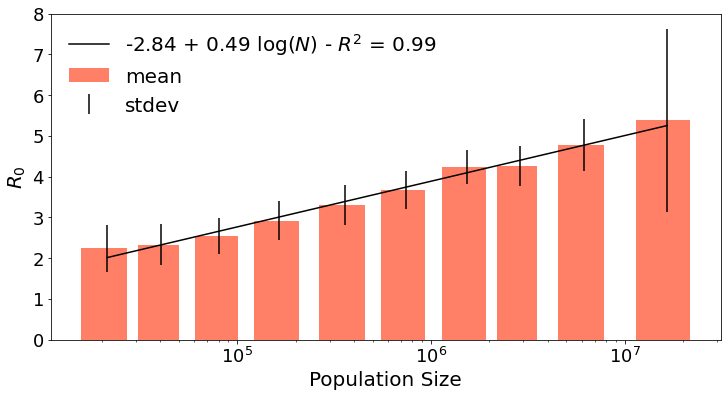

In [46]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

x_pop = df_eua_select['POP_mean'].to_numpy(); x_pop = np.insert(x_pop, 0, 1e4)
y = df_eua_select['R0_mean'].to_numpy()

def test_log(x, a, b):
    return a + b * np.log(x)

param_pop, param_cov_pop = curve_fit(test_log, x_pop[1:], y)
z_pop = test_log(x_pop[1:], param_pop[0], param_pop[1])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.bar(x_pop[1:], y, width = np.diff(x_pop),  align = 'center', color = '#ff8066', label = 'mean')
ax.errorbar(x_pop[1:], y, yerr = df_eua_select['R0_std'], xerr = None, ls = 'none',
               color = 'k', label = 'stdev')
ax.plot(x_pop[1:], z_pop, '-', c = 'black', label = r'%.2f + %.2f $\log (N)$ - $R^{2}$ = %.2f' %(param_pop[0], param_pop[1], r2_score(y, z_pop)))
ax.set_xscale('log')
ax.tick_params(axis = 'both', labelsize = 18)

ax.set_ylabel(r'$R_0$', fontsize = 20)
ax.set_xlabel(r'Population Size', fontsize = 20)
ax.legend(frameon = False, loc = 'best', fontsize = 20)
plt.show()

In [65]:
# x_rho = df_eua_select['RHO_mean'].to_numpy(); x_rho = np.insert(x_rho, 0, 1)

# param_rho, param_cov_rho = curve_fit(test_log, x_rho[1:], y)
# z_rho = test_log(x_rho[1:], param_rho[0], param_rho[1])


# fig, ax = plt.subplots(1, 1, figsize = (12, 6))

# ax.bar(x_rho[1:], y, width = np.diff(x_rho),  align = 'center', color = '#ff8066', label = 'mean')
# ax.errorbar(x_rho[1:], y, yerr = df_eua_select['R0_std'], xerr = None, ls = 'none',
#                color = 'k', label = 'stdev')
# ax.plot(x_rho[1:], z_rho, '-', c = 'black', label = r'%.2f + %.2f $\log (N)$ - $R^{2}$ = %.2f' %(param_rho[0], param_rho[1], r2_score(y, z_rho)))
# ax.set_xscale('log')
# ax.tick_params(axis = 'both', labelsize = 18)

# ax.set_ylabel(r'$R_0$', fontsize = 20)
# ax.set_xlabel(r'Population Density $(km^{-2})$', fontsize = 20)
# ax.legend(frameon = False, loc = 'best', fontsize = 20)
# plt.show()